# BRI Score: Collection Score Model

## Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from scipy import stats
from scipy.stats import uniform, randint

from skorecard.bucketers import DecisionTreeBucketer, OptimalBucketer, EqualFrequencyBucketer, EqualWidthBucketer, AgglomerativeClusteringBucketer
from skorecard.preprocessing import WoeEncoder
from skorecard.pipeline import BucketingProcess
from sklearn.pipeline import make_pipeline
from skorecard.pipeline.pipeline import SkorecardPipeline, to_skorecard_pipeline
from skorecard import Skorecard
from skorecard.rescale import ScoreCardPoints
from skorecard.bucketers import UserInputBucketer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, roc_curve, roc_auc_score, auc, log_loss, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from itertools import combinations
import shap
import time
import re
import pickle
import joblib
from openpyxl import load_workbook

import os
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import random
import string

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 600)

(CVXPY) Jul 29 01:17:55 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jul 29 01:17:55 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


## Functions

In [2]:
def props_good_bad(data, bad_flag, grouped_by):
    _ = data.groupby(grouped_by).size().reset_index().rename(columns={0: 'count'})
    zero = data[data[bad_flag] == 0].groupby(grouped_by).size().reset_index().rename(columns={0: 'co_good'})['co_good']
    one = data[data[bad_flag] == 1].groupby(grouped_by).size().reset_index().rename(columns={0: 'co_bad'})['co_bad']
    result = pd.concat([_, zero, one], axis=1)
    result['props_good'] = result['co_good'] / result['count']
    result['props_bad'] = result['co_bad'] / result['count']
    
    return result

def train_test_prop(train, test):
    tr_s = train.shape[0]
    te_s = test.shape[0]
    total = tr_s + te_s
    
    tr_p = str(round((tr_s / total) * 100)) + '%'
    te_p = str(round((te_s / total) * 100)) + '%'
    
    return f'{tr_p} : {te_p}'

def train_test_info(train, test, flag):
    print(f'Train shape: {train.shape}; Test shape: {test.shape}')
    print(train_test_prop(train, test))
    print()
    print('Train Flag Proportion:')
    print(train[flag].value_counts())
    print(train[flag].value_counts(normalize=True))
    print()
    print('Test Flag Proportion:')
    print(test[flag].value_counts())
    print(test[flag].value_counts(normalize=True))

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def calculate_gini(df, flag, name='train'):
    fpr, tpr, thresholds = roc_curve(df[flag], df['predict_proba'])
    roc_auc = auc(fpr, tpr)
    
    return 'Gini ' + name + ' = ' + str(round(2 * roc_auc - 1, 2))

def calc_gini(df, flag):
    fpr, tpr, thresholds = roc_curve(df[flag], df['predict_proba'])
    roc_auc = auc(fpr, tpr)
    
    return round(2 * roc_auc - 1, 2)

def print_gini(train, test, flag):
    print(calculate_gini(train, flag, 'train'))
    print(calculate_gini(test, flag, 'test'))
    
def plot_roc_curve(fpr, tpr, auc_score):
    gini_index = (2*auc_score)-1
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='navy', lw=lw, label='AUC Score = %0.3f\nGini Index = %0.3f' % (auc_score, gini_index))
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Model A-Score')
    plt.legend(loc="lower right")
    
    plt.show()
    return

def draw_auc(df, flag):
    fpr, tpr, thresholds = roc_curve(df[flag], df['predict_proba'])
    roc_auc = metrics.auc(fpr, tpr)
    # Draw Chart
    plot_title = get_df_name(df)
    plt.title('Receiver Operating Characteristic (%s)' %plot_title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def summary_auc(flag, train, test, val=None):
    draw_auc(train, flag)
    
    if val != None:
        draw_auc(val, flag)
        
    draw_auc(test, flag)
    
def final_bin(df, flag):

#     percentile = pd.DataFrame(df['cifno'])
    percentile = pd.DataFrame()
    percentile['probability'] = df['predict_proba']
    percentile['actual_flag_1'] = df[flag]
    percentile.sort_values(by=['probability'], ascending=False, inplace=True)
    
    percentile.reset_index(inplace=True)
    del percentile['index']
    percentile.reset_index(inplace=True)
    percentile['decile'] = pd.cut(percentile['index'], 10, labels=False, duplicates='drop')+1
    
    percentile.sort_values(by=['probability'], inplace=True, ascending=False)
    
    percentile[['decile', 'probability']].groupby(['decile']).max().sort_values(by=['decile'], ascending=True)
    del percentile['index']
    
    percentile['bins'] = pd.qcut(percentile['probability'], 10, duplicates = 'drop') # 10 -> 100
    
    return percentile.groupby('bins').agg({'actual_flag_1': [len, 'mean', 'sum'], 'probability': 'mean'})

def decile(df, flag, pred='predict_proba', bin=10, ascending=True):
#     percentile = pd.DataFrame(test['cifno'])
    percentile = pd.DataFrame()
    percentile['probability'] = df[pred] #
    percentile['actual_flag_1'] = df[flag]
    percentile.sort_values(by=['probability'], ascending=False, inplace=True)
    
    percentile.reset_index(inplace=True)
    del percentile['index']
    percentile.reset_index(inplace=True)
    percentile['decile'] = pd.cut(percentile['index'], bin, labels=False, duplicates='drop')+1
    
    percentile.sort_values(by=['probability'], inplace=True, ascending=False)
    
    # percentile[['decile', 'probability']].groupby(['decile']).max().sort_values(by=['decile'], ascending=True)
    del percentile['index']
    
    tes0 = pd.crosstab(percentile['decile'], percentile['actual_flag_1'])
    tes = pd.crosstab(percentile['decile'], percentile['actual_flag_1'], normalize='index')
    tes2 = percentile.groupby(['decile'])[['probability']].min()
    tes3 = percentile.groupby(['decile'])[['probability']].max()
    
    temp_df = pd.DataFrame(tes[0])
    temp_df['1'] = tes[1]
    temp_df['actual_flag_0'] = tes0[0]
    temp_df['actual_flag_1'] = tes0[1]
    temp_df['min_range'] = tes2
    temp_df['max_range'] = tes3
    
    temp_df = temp_df.rename(columns={0:'flag_0', '1':'flag_1'})
    
    temp_df['population'] = temp_df['actual_flag_0'] + temp_df['actual_flag_1']
    temp_df['mean'] = temp_df['actual_flag_1'] / percentile['actual_flag_1'].sum()
    
    temp_df = temp_df[['min_range', 'max_range', 'flag_0', 'flag_1', 'population', 'actual_flag_0', 'actual_flag_1', 'mean']]

    def calculate_cumulative_bad_rate(row):
        
        cumulative_actual_flag_1 = temp_df.loc[:row.name, 'actual_flag_1'].sum()
        cumulative_population = temp_df.loc[:row.name, 'population'].sum()
        
        return cumulative_actual_flag_1 / cumulative_population
    
    if ascending == False:
        temp_df = temp_df.reset_index().sort_values('decile', ascending=False).drop('decile', axis=1)
        temp_df.insert(0, 'decile', [i+1 for i in range(bin)])
        temp_df = temp_df.set_index('decile')

        temp_df['cum_flag_1_rate'] = temp_df.apply(calculate_cumulative_bad_rate, axis=1)
        
        return temp_df

    temp_df['cum_flag_1_rate'] = temp_df.apply(calculate_cumulative_bad_rate, axis=1)
        
    return temp_df

def feat_bins_agg_comp(df_raw, feature, anch_grp, bins, target_var, duplicates='drop'):
    
    all_viz = df_raw[[anch_grp, feature, target_var]]
    
    if (all_viz[feature].dtype == 'object') or (all_viz[feature].nunique() <= 3):
        all_viz[feature] = all_viz[feature].fillna('missing')
        
        
        
        view1 = all_viz.groupby([anch_grp, feature]).agg({target_var:['mean']}).unstack(level = 0)
        view2 = all_viz.groupby([anch_grp, feature]).agg({feature:[len]})
        view2 = (view2 / view2.groupby(level=0).sum()).unstack()
        view3=all_viz.groupby([anch_grp, feature]).agg({target_var:['mean','count']}).unstack(level = 0)
    
    else:
        all_viz['bin'] = pd.qcut(all_viz[feature],bins,duplicates=duplicates)

        if all_viz[feature].isna().sum() > 0:
            all_viz['bin'] = all_viz['bin'].cat.add_categories('missing')
            all_viz['bin'] = all_viz['bin'].fillna('missing')

        view1 = all_viz.groupby([anch_grp, 'bin']).agg({target_var:['mean']}).unstack(level = 0)
        view2 = all_viz.groupby([anch_grp, 'bin']).agg({feature:[len]})
        view2 = (view2 / view2.groupby(level=0).sum()).unstack()
        view3 = all_viz.groupby([anch_grp, 'bin']).agg({target_var:['mean','count']}).unstack(level = 0)
        
    print(feature)
    
    display(view3)
    view1.plot.bar(rot = 80, figsize = [7,3])
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title= 'mean_'+target_var)
    plt.xlabel('bin_'+feature)
    plt.show()

def model_pipeline(train, test, model, feat_list, corr_threshold=0.7, drop=[], sort_cat=True, desired_feat_len=None):

    model.fit(train[feat_list], train[flag])

    # PREDICT
    train['predict_proba'] = model.predict_proba(train[feat_list])[:,1]
    test['predict_proba'] = model.predict_proba(test[feat_list])[:,1]
    
    # PRINT GINI
    print_gini(train, test, flag)
    print()

    # FEAT TO ELIMINATE
    feat_elim = []
    
    # MATRIX CORRELATIONS
    corr_matrix = train[feat_list].corr()
    threshold = corr_threshold
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    if len(high_corr_pairs) == 0:
        print(f"No highly correlated pairs (correlation threshold > {threshold}).\n")
    # else:
    #     print(f"Highly correlated pairs (correlation > {threshold}):")
    #     display(high_corr_pairs)
    
    # FEATURE IMPORTANCE
    feature_importance = pd.Series(model.feature_importances_, train[feat_list].columns).sort_values(ascending = False).reset_index().rename(columns={'index': 'Features', 0: 'Feature Importance'})
    
    # VIF
    # vif_data = pd.DataFrame()
    # vif_data["Features"] = feat_list
    # vif_data["VIF"] = [variance_inflation_factor(train[feat_list].fillna(0).values, i) for i in range(len(feat_list))]
    # coefficients = feature_importance.merge(vif_data, on='Features', how='inner')
    coefficients = feature_importance
    
    # ecommerce = ['st score']
    # slik = ['co_cred_tunggak', 'co_cred_konsumsi_lunas', 'sum_vol_cred_konsumsi_aktif', 'co_cred_kartu_kredit']
    # indeks = ['idm_mean', 'ipm_kota']
    # brilink = ['brikodes_jumlah_id_agen_median', 'brikodes_frekuensi_transaksi_all_median']
    # aktivitas_lokal = [
    #     'brikodes_sum_lending_plafond_median',
    #     'brikodes_sum_lending_payment_amount_seg_kecil_median',
    #     'brikodes_sum_lending_payment_amount_mikro_median',
    #     'brikodes_sum_lending_payment_amount_kur_median',
    #     'brikodes_frekuensi_trx_atm_all_sum',
    #     'brikodes_sum_cbal_base_casa_sum',
    # ]

    # def categorize_feature(value):
    #     if value in ecommerce:
    #         return 'E-Commerce'
    #     elif value in slik:
    #         return 'SLIK'
    #     elif value in indeks:
    #         return 'Indeks Kota atau Desa'
    #     elif value in brilink:
    #         return 'BRILink'
    #     elif value in aktivitas_lokal:
    #         return 'Local Activity'
    #     else:
    #         return 'BRI'
    # coefficients['Category'] = coefficients['Features'].apply(categorize_feature)
    
    if sort_cat:
        coefficients = coefficients.sort_values(['Category', 'Feature Importance', 'VIF'], ascending=[True, False, True])
    else:
        coefficients = coefficients.sort_values(['Feature Importance'], ascending=[False])

    if len(high_corr_pairs) > 0:
        for feat1, feat2, corr_value in high_corr_pairs:
            feat1_importance = coefficients.loc[coefficients['Features'] == feat1, 'Feature Importance'].values[0]
            feat2_importance = coefficients.loc[coefficients['Features'] == feat2, 'Feature Importance'].values[0]
            
            if feat1_importance < feat2_importance:
                lowest_feature = feat1
            else:
                lowest_feature = feat2

            lowest_feat_importance = coefficients.loc[coefficients['Features'] == lowest_feature, 'Feature Importance'].values[0]

            print(f"Highly correlated pairs (correlation > {threshold})\n")
            print(f"Feat 1: {feat1}")
            print(f"Feat 2: {feat2}")
            print(f"Corr Value: {corr_value}")
            print(f"Lowest Feat. Importance: {lowest_feature}")
            
            feat_elim.append(lowest_feature)

    if drop:
        for col in drop:
            filtered_df = coefficients[coefficients['Category'] == col]
            min_idx = filtered_df['Feature Importance'].idxmin()
            lowest_feature = filtered_df.loc[min_idx, 'Features']
            val_feature = filtered_df.loc[min_idx, 'Feature Importance']

            print("Lowest Feat. Importance")
            print(f"Category: {col}")
            print(f"Feat: {lowest_feature}")
            print(f"Value: {val_feature}\n")
            
            feat_elim.append(lowest_feature)

    print("Next recommended feat to be dropped")
    print(list(set(feat_elim)))

    feat_list = list(set(feat_list) - set(feat_elim))
    # display(coefficients)
    # display(coefficients[['Features', 'Feature Importance', 'Category']])

    return feat_list, coefficients

def feature_selection(train, test, model, feat_list, len_feat=100):

    model.fit(train[feat_list], train[flag])

    # PREDICT
    train['predict_proba'] = model.predict_proba(train[feat_list])[:,1]
    test['predict_proba'] = model.predict_proba(test[feat_list])[:,1]
    
    # PRINT GINI
    print_gini(train, test, flag)
    print()
    
    # FEATURE IMPORTANCE
    feature_importance = pd.Series(model.feature_importances_, train[feat_list].columns).sort_values(ascending = False).reset_index().rename(columns={'index': 'Features', 0: 'Feature Importance'})

    # CHECK FEAT LEN
    if len(feat_list) <= len_feat:
        print("Current Feat. Len")
        print(len(feat_list))
        display(feature_importance)
        return feature_importance['Features'].to_list()
        
    # NEXT FEAT
    if len(feat_list) > 200:
        n = -100
    elif len(feat_list) > 100:
        n = -50
    elif len(feat_list) > 50:
        n = -10
    else:
        n = -1
        
    feature_importance = feature_importance.iloc[:n]
    
    feat_list = feature_importance['Features'].to_list()

    print("Next Feat. Len:")
    print(len(feat_list))
    print()

    return feature_selection(train, test, model, feat_list, len_feat=len_feat)

def corr_selection(train, test, model, feat_list, corr_threshold=0.7):

    model.fit(train[feat_list], train[flag])

    # PREDICT
    train['predict_proba'] = model.predict_proba(train[feat_list])[:,1]
    test['predict_proba'] = model.predict_proba(test[feat_list])[:,1]
    
    # PRINT GINI
    print_gini(train, test, flag)
    print()

    # FEAT TO ELIMINATE
    feat_elim = []

    # MATRIX CORRELATIONS
    corr_matrix = train[feat_list].corr()
    threshold = corr_threshold
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    if len(high_corr_pairs) == 0:
        print(f"No highly correlated pairs (correlation threshold > {threshold}).\n")
        return feat_list
    
    # FEATURE IMPORTANCE
    feature_importance = pd.Series(model.feature_importances_, train[feat_list].columns).sort_values(ascending = False).reset_index().rename(columns={'index': 'Features', 0: 'Feature Importance'})

    if len(high_corr_pairs) > 0:
        for feat1, feat2, corr_value in high_corr_pairs:
            feat1_importance = feature_importance.loc[feature_importance['Features'] == feat1, 'Feature Importance'].values[0]
            feat2_importance = feature_importance.loc[feature_importance['Features'] == feat2, 'Feature Importance'].values[0]
            
            if feat1_importance < feat2_importance:
                lowest_feature = feat1
            else:
                lowest_feature = feat2

            lowest_feat_importance = feature_importance.loc[feature_importance['Features'] == lowest_feature, 'Feature Importance'].values[0]

            # print(f"Highly correlated pairs (correlation > {threshold})\n")
            # print(f"Feat 1: {feat1}")
            # print(f"Feat 2: {feat2}")
            # print(f"Corr Value: {corr_value}")
            # print(f"Lowest Feat. Importance: {lowest_feature}")
            
            feat_elim.append(lowest_feature)

    print("Correlated Features Len:")
    print(len(high_corr_pairs))
    print()
    
    feature_importance = feature_importance[~feature_importance['Features'].isin(feat_elim)]
    
    feat_list = feature_importance['Features'].to_list()

    print("Next Feat. Len:")
    print(len(feat_list))
    print()

    return corr_selection(train, test, model, feat_list)

## Read Dataset

In [3]:
df = pd.read_csv("final_briscore_cscore.csv") # briscore_cscore_dataset_final.csv -> Final Dataset with Final Features
df.shape

(589080, 598)

In [4]:
props_good_bad(df[df['porto'] == 'CERIA'], 'flag_bad', 'bucket_dpd')[['bucket_dpd', 'co_bad', 'props_bad']]

,bucket_dpd,co_bad,props_bad
0,3,41321,0.423705
1,4,15032,0.215816
2,5,5621,0.089843


In [5]:
props_good_bad(df[df['porto'] == 'CC'], 'flag_bad', 'bucket_dpd')[['bucket_dpd', 'co_bad', 'props_bad']]

,bucket_dpd,co_bad,props_bad
0,2,68278,0.438269
1,3,23246,0.260550
2,4,14144,0.214147
3,5,4343,0.089949


## Bad Rate Overall

In [6]:
df['flag_bad'].value_counts(normalize=True)

flag_bad
0    0.708045
1    0.291955
Name: proportion, dtype: float64

### 4.1. Bad Rate CERIA

In [7]:
df[df['porto'] == 'CERIA']['flag_bad'].value_counts(normalize=True)

flag_bad
0    0.730243
1    0.269757
Name: proportion, dtype: float64

### 4.2. Bad Rate CC

In [8]:
df[df['porto'] == 'CC']['flag_bad'].value_counts(normalize=True)

flag_bad
0    0.693853
1    0.306147
Name: proportion, dtype: float64

## Dataset Accross Cohort

In [9]:
props_good_bad(df, 'flag_bad', 'ds')

,ds,count,co_good,co_bad,props_good,props_bad
0,202208,30384,20301,10083,0.668148,0.331852
1,202209,35406,24772,10634,0.699655,0.300345
2,202210,38889,26942,11947,0.692792,0.307208
3,202211,42505,29210,13295,0.687213,0.312787
4,202212,44200,31582,12618,0.714525,0.285475
5,202301,51959,37318,14641,0.718220,0.281780
6,202302,61994,41533,20461,0.669952,0.330048
7,202303,60609,41668,18941,0.687489,0.312511
8,202304,56315,41245,15070,0.732398,0.267602
9,202305,54652,39438,15214,0.721620,0.278380


## Feature Engineering

In [10]:
# df_final_briscore['initial_limit'] = np.where((df_final_briscore['dataset'] == 'RYAN'), np.nan, df_final_briscore['initial_limit'])
# df_final_briscore['max_dpd_l3m'] = np.where((df_final_briscore['dataset'] == 'RYAN'), np.nan, df_final_briscore['max_dpd_l3m'])

### 6.1. Label Encoding

In [11]:
flag = 'flag_bad'

non_feat = [
    'porto',
    'ongoing_branch',
    'first_branch',
    'last_branch',
    'cifno',
    'flag_bad',
    'cif_id',
    'acid',
    'oda',
    'cm_card_nmbr',
    'trx_date',
    'event_date',
    'cohort',
    'ds',
    'saving_register_region_na_first',
    'saving_mapp_register_region_na_first',
    'saving_register_region_na_last',
    'saving_mapp_register_region_na_last',
    'loan_product_type_na_na',
    'brimo_create_na_date_na',
    'brimo_create_na_date_min_na',
    'brimo_create_na_date_max_na',
    'brimo_trx_lastdt_na_na',
    'loan_open_date',
    'loan_type',
    'ongoing_rgdesc',
    'first_rgdesc',
    'last_rgdesc',
    'product',
    'demog_personal_tanggal_lahir_na_na',
    'demog_personal_agama_na_na',
    'demog_personal_status_nikah_na_na',
    'saving_min_opdate',
    'open_date',
    'cif_nasabah',
    'loan_product_type_na_na', 
    'first_rgdesc', 
    'saving_register_region_na_last', 
    'saving_register_region_na_first',
    'brimo_create_na_date_min_na',
    'saving_mapp_register_region_na_last',
    'ongoing_rgdesc',
    'last_rgdesc',
    'brimo_trx_lastdt_na_na',
    'brimo_create_na_date_max_na',
]

all_feat = list(set(df.columns.to_list()) - set(non_feat))
all_feat.sort()

len(all_feat)

578

In [12]:
non_feat_drop = [i for i in non_feat if i in df.columns.to_list()]

feat_str = df.drop(non_feat_drop, axis=1).select_dtypes(include=['category', 'object']).columns.tolist()
len(feat_str)

0

In [13]:
for i, feat in enumerate(feat_str):
    print((i+1), feat)
    le = LabelEncoder()
    df[feat] = le.fit_transform(df[feat])

## Split Dataset

In [80]:
flag = 'flag_bad'

In [81]:
train = df[df['ds'].astype('int') <= 202303]
test = df[df['ds'].astype('int') > 202303]

train_test_info(train, test, flag)

Train shape: (365946, 600); Test shape: (223134, 600)
62% : 38%

Train Flag Proportion:
flag_bad
0    253326
1    112620
Name: count, dtype: int64
flag_bad
0    0.69225
1    0.30775
Name: proportion, dtype: float64

Test Flag Proportion:
flag_bad
0    163769
1     59365
Name: count, dtype: int64
flag_bad
0    0.733949
1    0.266051
Name: proportion, dtype: float64


## Final Features

In [82]:
all_feat = df.columns.to_list()

elim_feat = [
    'cifno',
    'ds',
    'flag_bad',
    'porto',
    'loan_product_type_na_na', 
    'first_rgdesc', 
    'saving_register_region_na_last', 
    'saving_register_region_na_first',
    'brimo_create_na_date_min_na',
    'saving_mapp_register_region_na_last',
    'ongoing_rgdesc',
    'last_rgdesc',
    'brimo_trx_lastdt_na_na',
    'brimo_create_na_date_max_na',
    'saving_mapp_register_region_na_first',
    'open_date',
    'bucket_flag',
]

feat_list = list(set(all_feat) - set(elim_feat))
len(feat_list)

583

In [86]:
feat_list = [    
    'saving_casatd_aktif_sum_na',
    'bucket_dpd',
    'ddhist_trx_credit_count_l30d',
    'brimo_trx_na_count_l90d',
    'ddhist_trx_debit_count_l90d',
    'transaction_ratio_cocasa_cotrxcred_na_l30d',
    'collection_act_rsch_count_l1m',
    'spending_trx_consumerloans_count_l90d',
    'ddhist_trend_trxcred_sum_l90d',
    'rt_avg_outs_1_3'
]

len(feat_list)

10

## Model Fitting

In [87]:
%%time

model = XGBClassifier(
    # base_score=0.5,
    # importance_type=None,
    # interaction_constraints='',
    # colsample_bylevel=1,
    # colsample_bynode=1,
    # colsample_bytree=1,
    # enable_categorical=False,
    # max_delta_step=2,
    max_depth=5, ##
    # min_child_weight=3, ##
    n_estimators=200, ##
    # num_parallel_tree=1,
    # scale_pos_weight=1,
    # subsample=0.8,
    eta=0.09, ##  #learning rate
    gamma=0.1, ## #Min loss reduction required to make a further partition on a leaf node
    reg_alpha=0.5, ##
    reg_lambda=0.5, ##
    
    random_state=11,
    seed=42,
    n_jobs=-1,
    eval_metric='auc',
    predictor='auto',
    booster='gbtree',
    verbosity=1,
    # gpu_id=-1,
    # tree_method='gpu_hist'
)

model.fit(train[feat_list], train[flag])

# PREDICT
train['predict_proba'] = model.predict_proba(train[feat_list])[:,1]
test['predict_proba'] = model.predict_proba(test[feat_list])[:,1]

# PRINT GINI
print_gini(train, test, flag)
print()

Gini train = 0.62
Gini test = 0.59

CPU times: user 53.3 s, sys: 646 ms, total: 54 s
Wall time: 12.8 s


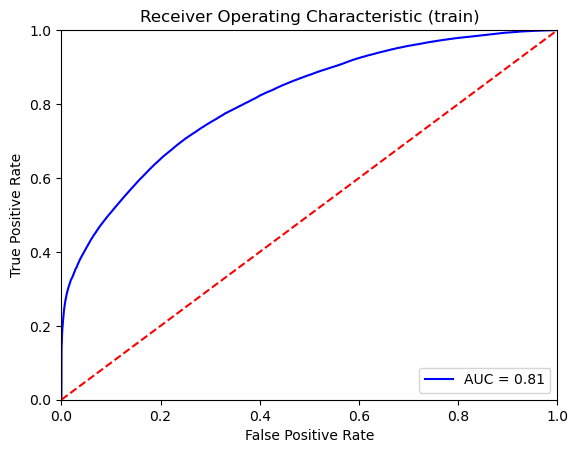

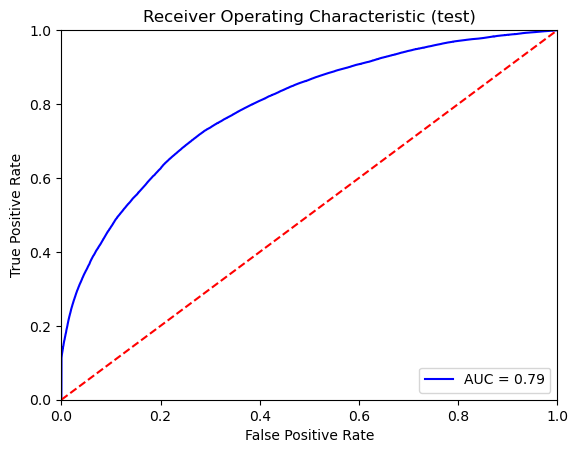

In [88]:
summary_auc(flag, train, test)

## Feature Analysis

### 10.1. Feature Importance

<Axes: title={'center': 'Feature Importances'}, xlabel='Features'>

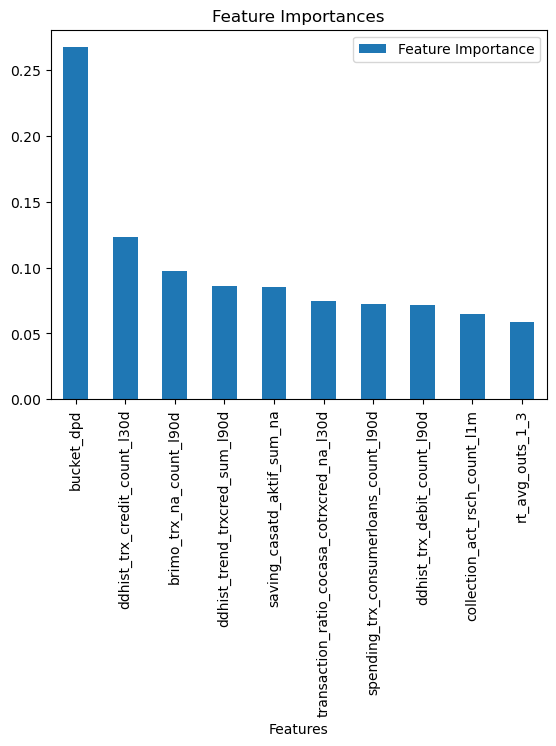

In [89]:
feature_importance = pd.Series(model.feature_importances_, train[feat_list].columns).sort_values(ascending = False).reset_index().rename(columns={'index': 'Features', 0: 'Feature Importance'})
feature_importance.set_index('Features').iloc[:20].plot(kind='bar', title='Feature Importances')

### 10.2. VIF (Multicolinearity)

In [239]:
%%time
    
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Features"] = feat_list
  
# calculating VIF for each f|eature
vif_data["VIF"] = [variance_inflation_factor(train[feat_list].fillna(0).values, i)
                          for i in range(len(feat_list))]

CPU times: user 1.86 s, sys: 489 ms, total: 2.35 s
Wall time: 1.44 s


In [240]:
coefficients = feature_importance.merge(vif_data, on='Features', how='inner')
coefficients.sort_values(['Feature Importance', 'VIF'], ascending=[False, True])

,Features,Feature Importance,VIF
0,bucket_dpd,0.250790,4.116203
1,ddhist_trx_credit_count_l30d,0.119374,1.014348
2,brimo_trx_na_count_l90d,0.094312,1.076682
3,ddhist_trend_trxcred_sum_l90d,0.083530,1.000066
4,saving_casatd_aktif_sum_na,0.082783,1.000217
5,spending_trx_consumerloans_count_l90d,0.071047,1.242216
6,loan_acct_kpp_count_na,0.067797,1.034352
7,transaction_ratio_cocasa_cotrxcred_na_l30d,0.062396,1.269906
8,collection_act_rsch_count_l1m,0.061883,1.009943
9,ddhist_trx_debit_count_l90d,0.058385,1.001074


### 10.3. Correlation

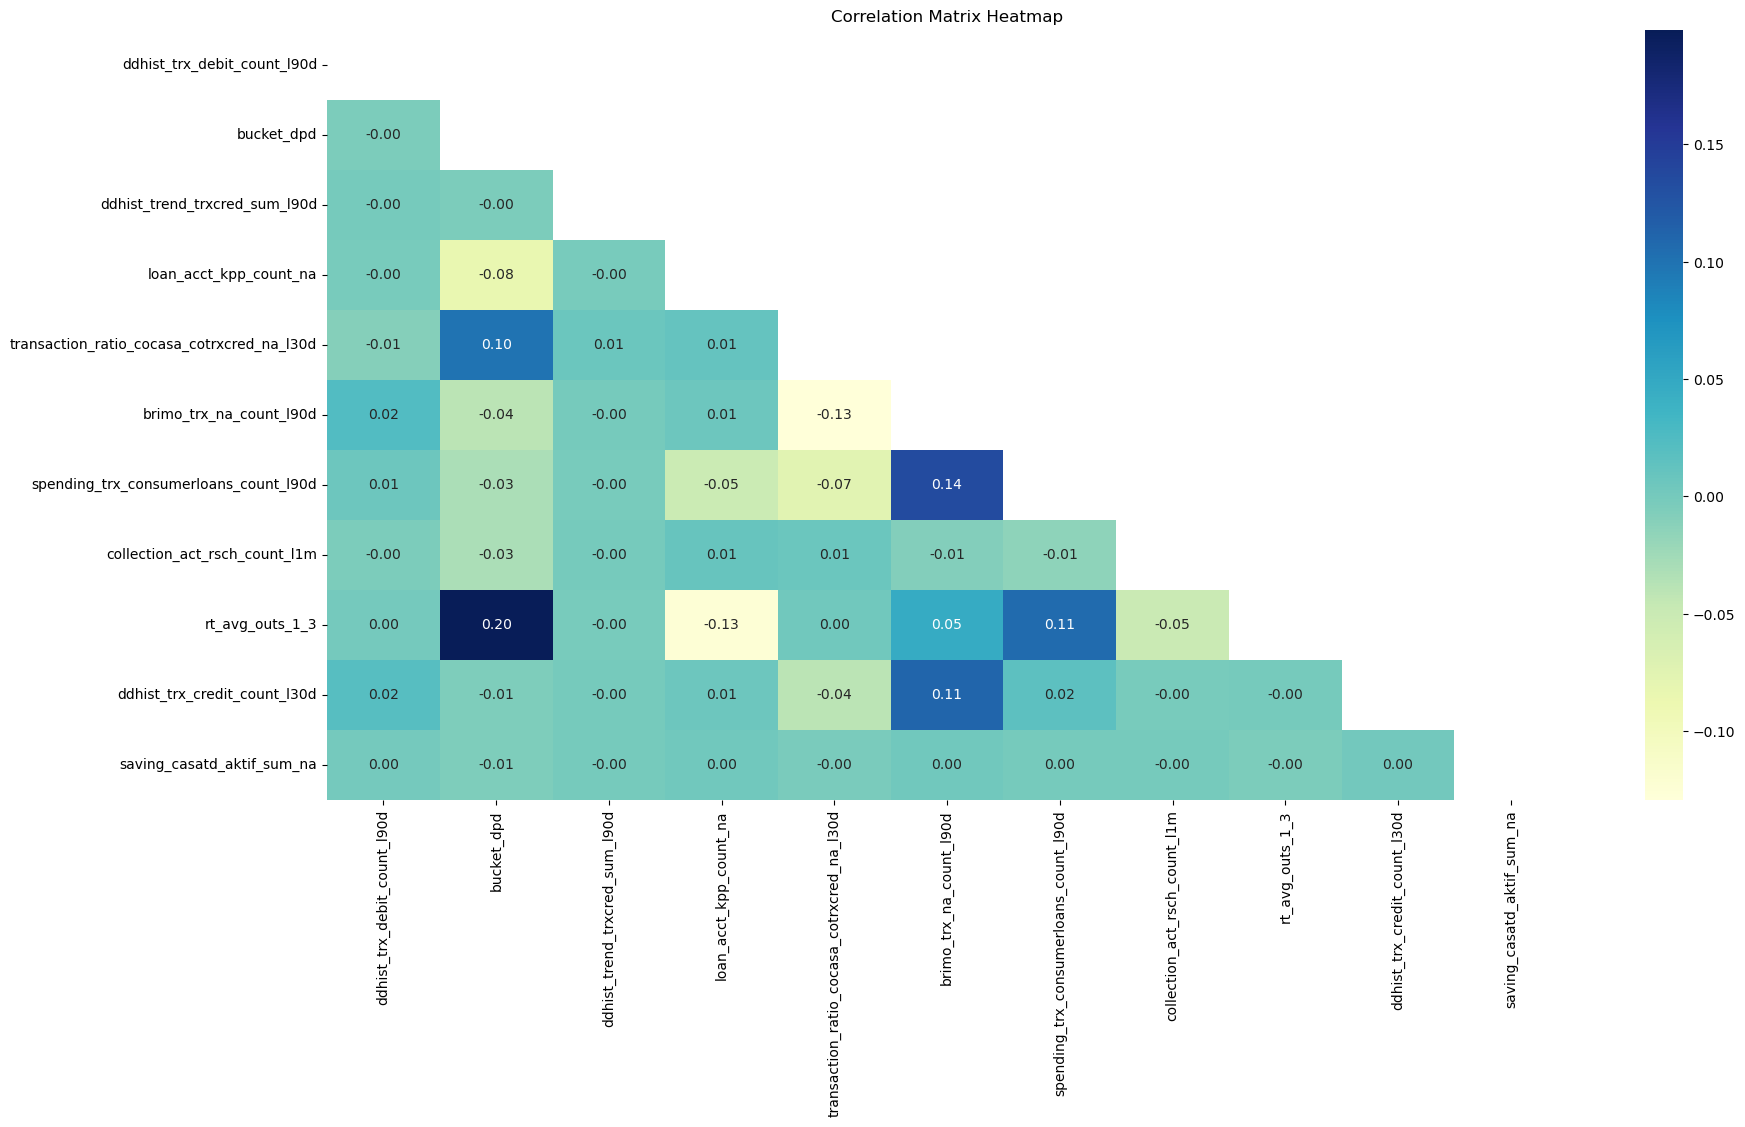

In [241]:
corr_matrix = train[feat_list].corr()

mask = np.triu(np.ones_like(corr_matrix))
plt.figure(figsize=(20, 10))
dataplot = sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='YlGnBu', mask=mask)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Find High Correlated Features

In [243]:
threshold = 0.7
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

high_corr_pairs

[]

## Pipeline

### 11.1. Selected Features

In [139]:
# feat_list = [
#     'saving_dep_aktif_idr_count_na',
#     'bucket_dpd',
#     'saving_against_sumcaaktif_sumtdaktif_na_na',
#     'saving_giro_nonaktif_idr_sum_na',
#     'ddhist_trx_credit_count_l30d',
#     'saving_tab_aktif_nonidr_sum_na',
#     'loan_acct_kpp_count_na',
#     'brimo_trx_na_count_l90d',
#     'ddhist_trx_debit_count_l90d',
#     'transaction_ratio_cocasa_cotrxcred_na_l30d',
#     'collection_act_rsch_count_l1m',
#     'spending_trx_consumerloans_count_l90d',
#     'transaction_diff_cotrxcred_cotrxdeb_na_l30d',
#     'ddhist_trend_trxcred_sum_l90d',
#     'saving_dep_nonaktif_idr_sum_na',
#     'rt_avg_outs_1_3'
# ]

# len(feat_list)

### 11.2. Final Features

In [90]:
feat_list = [    
    'saving_casatd_aktif_sum_na',
    'bucket_dpd',
    'ddhist_trx_credit_count_l30d',
    # 'loan_acct_kpp_count_na',
    'brimo_trx_na_count_l90d',
    'ddhist_trx_debit_count_l90d',
    'transaction_ratio_cocasa_cotrxcred_na_l30d',
    'collection_act_rsch_count_l1m',
    'spending_trx_consumerloans_count_l90d',
    # 'transaction_diff_cotrxcred_cotrxdeb_na_l30d',
    'ddhist_trend_trxcred_sum_l90d',
    'rt_avg_outs_1_3'
]

len(feat_list)

10

### 11.3. Fitting

In [93]:
%%time

model = XGBClassifier(
    # base_score=0.5,
    # importance_type=None,
    # interaction_constraints='',
    # colsample_bylevel=1,
    # colsample_bynode=1,
    # colsample_bytree=1,
    # enable_categorical=False,
    # max_delta_step=2,
    max_depth=5, ##
    # min_child_weight=3, ##
    n_estimators=200, ##
    # num_parallel_tree=1,
    # scale_pos_weight=1,
    # subsample=0.8,
    eta=0.09, ##  #learning rate
    gamma=0.1, ## #Min loss reduction required to make a further partition on a leaf node
    reg_alpha=0.5, ##
    reg_lambda=0.5, ##
    
    random_state=11,
    seed=42,
    n_jobs=-1,
    eval_metric='auc',
    predictor='auto',
    booster='gbtree',
    verbosity=1,
    # gpu_id=-1,
    # tree_method='gpu_hist'
)

# model.fit(train[feat_list], train[flag])

# corr_threshold = 0.7
final_feat_list = feature_selection(train, test, model, feat_list, len_feat=10)
# final_feat_list = corr_selection(train, test, model, feat_list, corr_threshold)

# feat_list, coefficients = model_pipeline(train, test, model, feat_list, corr_threshold=corr_threshold, drop=[], sort_cat=False)

Gini train = 0.62
Gini test = 0.59

Current Feat. Len
10


,Features,Feature Importance
0,bucket_dpd,0.267080
1,ddhist_trx_credit_count_l30d,0.122863
2,brimo_trx_na_count_l90d,0.097077
3,ddhist_trend_trxcred_sum_l90d,0.086268
4,saving_casatd_aktif_sum_na,0.085387
5,transaction_ratio_cocasa_cotrxcred_na_l30d,0.074247
6,spending_trx_consumerloans_count_l90d,0.072324
7,ddhist_trx_debit_count_l90d,0.071852
8,collection_act_rsch_count_l1m,0.064435
9,rt_avg_outs_1_3,0.058468


CPU times: user 53.8 s, sys: 680 ms, total: 54.5 s
Wall time: 13.2 s


## Final Binning

In [99]:
decile(xgb_test, flag, ascending=False)

,min_range,max_range,flag_0,flag_1,population,actual_flag_0,actual_flag_1,mean,cum_flag_1_rate
decile,,,,,,,,,
1,0.011444,0.059957,0.953841,0.046159,22314,21284,1030,0.017350,0.046159
2,0.059958,0.096286,0.930175,0.069825,22313,20755,1558,0.026244,0.057992
3,0.096286,0.149236,0.890467,0.109533,22313,19869,2444,0.041169,0.075172
4,0.149239,0.187712,0.873129,0.126871,22314,19483,2831,0.047688,0.088097
5,0.187715,0.236816,0.827410,0.172590,22313,18462,3851,0.064870,0.104995
6,0.236816,0.301032,0.785596,0.214404,22313,17529,4784,0.080586,0.123230
7,0.301041,0.392467,0.698127,0.301873,22314,15578,6736,0.113468,0.148751
8,0.392469,0.491487,0.633846,0.366154,22313,14143,8170,0.137623,0.175926
9,0.491495,0.841418,0.521400,0.478600,22313,11634,10679,0.179887,0.209556


## Repayment Score

In [97]:
xgb_train = train[['predict_proba', 'ds', flag, *feat_list]].copy()
xgb_test = test[['predict_proba', 'ds', flag, *feat_list]].copy()

In [142]:
xgb_train['logodds'] = xgb_train['predict_proba'].apply(lambda x: np.log((1 - x) / x))
xgb_test['logodds'] = xgb_test['predict_proba'].apply(lambda x: np.log((1 - x) / x))

In [143]:
xgb_data = pd.concat([xgb_train, xgb_test])

### 13.1. Get Min LogOdds

In [144]:
xgb_min_logodds = xgb_test['logodds'].min()
print(f'Min LogOdds: {xgb_min_logodds}')

Min LogOdds: -12.071178419908582


### 13.2. Get Max LogOdds

In [146]:
xgb_max_logodds = xgb_test['logodds'].max()
print(f'Max LogOdds: {xgb_max_logodds}')

Max LogOdds: 4.458753574657634


### 13.3. Search A and B

In [147]:
# Apply the risk factor formula
anchor = 485
pdo = 23.063
basic_odd = 3
intercept = 0

# Priority Calc
basic_score = anchor + (-pdo / np.log(2)) * (np.log(basic_odd) + intercept)

# Get A & B
A_xgb = basic_score
B_xgb = -pdo/np.log(2)

#### Get A

In [148]:
print(f'A = {A_xgb}')

A = 448.446009845868


#### Get B

In [149]:
print(f'B = {B_xgb}')

B = -33.272875728022164


### 13.4. Score Inference

In [150]:
xgb_train['xgb_score'] = A_xgb + B_xgb * xgb_train['logodds']
xgb_test['xgb_score'] = A_xgb + B_xgb * xgb_test['logodds']

In [176]:
decile(xgb_test, flag, ascending=False, pred='xgb_score')

,min_range,max_range,flag_0,flag_1,population,actual_flag_0,actual_flag_1,mean,cum_flag_1_rate
decile,,,,,,,,,
1,300.090456,356.869353,0.953841,0.046159,22314,21284,1030,0.017350,0.046159
2,356.869984,373.941596,0.930175,0.069825,22313,20755,1558,0.026244,0.057992
3,373.941596,390.531059,0.890467,0.109533,22313,19869,2444,0.041169,0.075172
4,390.531765,399.702933,0.873129,0.126871,22314,19483,2831,0.047688,0.088097
5,399.703766,409.509616,0.827410,0.172590,22313,18462,3851,0.064870,0.104995
6,409.509616,420.417313,0.785596,0.214404,22313,17529,4784,0.080586,0.123230
7,420.418670,433.907271,0.698127,0.301873,22314,15578,6736,0.113468,0.148751
8,433.907528,447.312912,0.633846,0.366154,22313,14143,8170,0.137623,0.175926
9,447.313999,503.972334,0.521400,0.478600,22313,11634,10679,0.179887,0.209556


<Axes: >

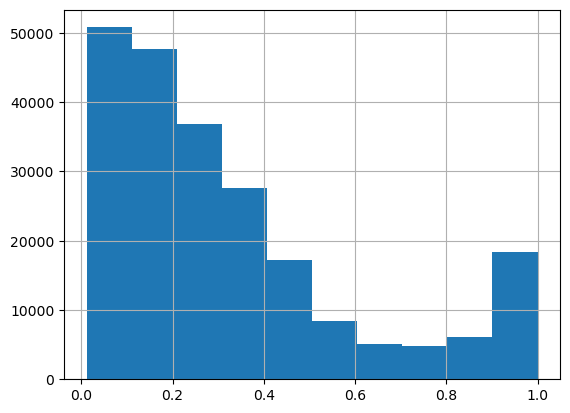

In [177]:
xgb_test['predict_proba'].hist()

<Axes: >

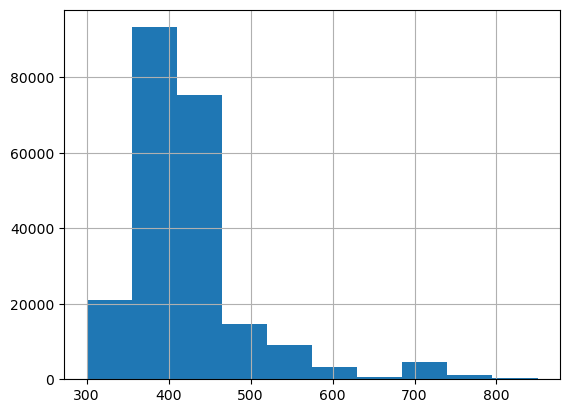

In [178]:
xgb_test['xgb_score'].hist()

### 13.5. Define Income

In [152]:
def create_equal_frequency_bins(df, score_column, num_bins=3, ascending=True):
    """
    Create equal-frequency bins from a specified column in the DataFrame and return aggregated min_range, max_range, and population for each bin.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - score_column (str): The column to bin.
    - num_bins (int): The number of bins to create. Default is 3.
    - ascending (bool): If True, the result DataFrame will be sorted in ascending order based on min_range. If False, it will be sorted in descending order. Default is True.

    Returns:
    - pd.DataFrame: A DataFrame with the min_range, max_range, and population for each bin.
    """
    # Ensure the score_column is numeric
    df[score_column] = pd.to_numeric(df[score_column], errors='coerce')
    
    # Drop rows with NaN values in score_column
    df = df.dropna(subset=[score_column])
    
    # Calculate bin edges for equal-frequency bins using quantiles
    quantiles = np.linspace(0, 1, num_bins + 1)
    bin_edges = df[score_column].quantile(quantiles).values
    
    # Create bins
    df['bin'] = pd.cut(df[score_column], bins=bin_edges, include_lowest=True, right=True)
    
    # Aggregate min_range, max_range, and population for each bin
    bin_ranges = df.groupby('bin')[score_column].agg(['min', 'max', 'size']).reset_index()
    bin_ranges.columns = ['bin', 'min_range', 'max_range', 'population']
    
    # Drop the 'bin' column and sort the DataFrame by min_range
    bin_ranges = bin_ranges.drop(columns='bin')
    bin_ranges = bin_ranges.sort_values(by='min_range', ascending=ascending).reset_index(drop=True)
    
    return bin_ranges

In [153]:
df_income = pd.concat([xgb_train, xgb_test])
df_income = pd.concat([df_income, df[['ddhist_income_payroll_avgsum_last3month', 'ddhist_trx_credit_avgsum_last3month']]])

In [154]:
df_income['income'] = df_income['ddhist_income_payroll_avgsum_last3month'].fillna(df['ddhist_trx_credit_avgsum_last3month'])
df_income['income'] = df_income['income'].fillna(3000000)
df_income['income'] = np.where(df_income['income'].isna() | df_income['income'] == 0, 3000000, df_income['income'])

#### Income < 3 Mio

In [161]:
create_equal_frequency_bins(df_income[df_income['income'] < 3000000], score_column='xgb_score', num_bins=3)

,min_range,max_range,population
0,300.090456,381.295668,55101
1,381.295846,415.405976,55102
2,415.406106,822.799942,55098


#### Income >= 3 Mio and < 5 Mio

In [162]:
create_equal_frequency_bins(df_income[(df_income['income'] >= 3000000) & (df_income['income'] < 5000000)], score_column='xgb_score', num_bins=3)

,min_range,max_range,population
0,306.233975,396.653508,79947
1,396.653708,432.798865,78435
2,432.799519,832.678728,78423


#### Income >= 5 Mio and < 10 Mio

In [163]:
create_equal_frequency_bins(df_income[(df_income['income'] >= 5000000) & (df_income['income'] < 10000000)], score_column='xgb_score', num_bins=3)

,min_range,max_range,population
0,300.348274,401.454688,20846
1,401.455223,433.889749,20845
2,433.890547,850.088829,20845


#### < 10 Mio (combined all under 10 Mio)

In [164]:
create_equal_frequency_bins(df_income[(df_income['income'] < 10000000)], score_column='xgb_score', num_bins=3)

,min_range,max_range,population
0,300.090456,392.755098,154890
1,392.755113,427.342048,154871
2,427.342083,850.088829,154881


#### Income >= 10 Mio and < 20 Mio

In [165]:
create_equal_frequency_bins(df_income[(df_income['income'] >= 10000000) & (df_income['income'] < 20000000)], score_column='xgb_score', num_bins=3)

,min_range,max_range,population
0,307.929592,405.858231,16934
1,405.858283,434.706204,16933
2,434.706709,844.370841,16934


#### Income >= 20 Mio

In [166]:
create_equal_frequency_bins(df_income[(df_income['income'] >= 20000000)], score_column='xgb_score', num_bins=3)

,min_range,max_range,population
0,307.98341,411.189228,24546
1,411.19192,437.692467,24545
2,437.69254,841.573134,24546


## Sampling

In [5]:
df_ceria = pd.read_parquet("dataset_model_v4.parquet")

In [6]:
df_ceria['ds'] = df_ceria['ds'].str[:6]
df_ceria['flag_bad'] = df_ceria['flag_target'].astype('int')
df_ceria['porto'] = 'CERIA'
df_ceria['bucket_dpd'] = df_ceria['bucket']
# df_ceria['mob'] = df_ceria['mob_ceria']
df_ceria['rt_avg_outs_3_6'] = df_ceria['max_outstanding_l3m'].astype('float') / df_ceria['max_outstanding_l6m'].astype('float')
df_ceria['rt_avg_outs_1_3'] = df_ceria['max_outstanding_l1m'].astype('float') / df_ceria['max_outstanding_l3m'].astype('float')
# df_ceria['collection_act_ptp_count_l6m'] = df_ceria['collection_ptp_count_l6m']
# df_ceria['collection_act_rsch_count_l1m'] = df_ceria['collection_act_rsch_count_l1m']
df_ceria.shape

(229740, 739)

In [7]:
df_cc = pd.read_parquet("dataset_cc_v4.parquet")
df_cc = df_cc[df_cc['cm_block_code'] != 'M']
df_cc['flag_bad'] = df_cc['roll'].astype('int')
df_cc['porto'] = 'CC'
df_cc.shape

(359340, 1093)

In [8]:
ceria_cols = df_ceria.columns.to_list()
cc_cols = df_cc.columns.to_list()

In [9]:
cols_exist = [i for i in cc_cols if i in ceria_cols]
len(cols_exist)

598

In [10]:
df = pd.concat([df_ceria[cols_exist], df_cc[cols_exist]])
df.shape

(589080, 598)

In [11]:
df['flag_bad'] = np.where(df['flag_bad'] == 1, 0, 1)

In [8]:
# CERIA
feat_ceria = [
    'min_amt_last_due_installment_l1m', 
    'datediff_from_last_trx', 
    'current_util', 
    'min_amt_repayment_l3m', 
    'collection_act_request_count_l1m', 
    'transaction_ratio_sumcasa_sumtrxdeb_na_l90d', 
    'ddhist_income_payroll_sum_last1month',
    'ddhist_trx_credit_debit_sum_last1month', 
    'max_amt_last_due_repayment_l6m',
]

# CC
feat_cc = [
    'month_since_30plus', 
    'month_since_90plus', 
    'month_since_pay', 
    'rt_rtlbal_l1m', 
    'n_overlimit_l6m',
    'mob',
    'rt_xplus_l12m', 
    'rt_avg_outs_1_3', 
    'collection_act_ptp_count_l6m', 
    'n_pay_l12m', 
    'rt_avg_outs_3_6',
    'rt_rtlnonoversea_trx_l3m', 
    'collection_act_rsch_count_l1m',
]

feat_list = list(set(feat_ceria + feat_cc))
len(feat_list)

22

In [75]:
exist_feat = [i for i in feat_list if i in ceria_cols and i in cc_cols]
len(exist_feat)

7

In [76]:
exist_feat

['collection_act_ptp_count_l6m',
 'rt_avg_outs_3_6',
 'rt_avg_outs_1_3',
 'collection_act_rsch_count_l1m',
 'ddhist_trx_credit_debit_sum_last1month',
 'ddhist_income_payroll_sum_last1month',
 'transaction_ratio_sumcasa_sumtrxdeb_na_l90d']

In [77]:
not_exist = [
    'month_since_30plus', 
    'collection_act_request_count_l1m', 
    'rt_rtlnonoversea_trx_l3m', 
    'rt_xplus_l12m', 
    'datediff_from_last_trx', 
    'n_pay_l12m', 
    'rt_avg_outs_1_3', 
    'n_overlimit_l6m', 
    'month_since_90plus', 
    'current_util', 
    'min_amt_last_due_installment_l1m', 
    'min_amt_repayment_l3m', 
    'max_amt_last_due_repayment_l6m', 
    'month_since_pay', 
    'rt_avg_outs_3_6', 
    'mob', 
    'rt_rtlbal_l1m'
]

len(not_exist)

17